# Lab 1: Detecting type of motion through clustering

Lucy Newman, Cho Yin Kong, Natalia Kisanga

---

In this lab, we collected motion data from a car in one of four possible conditions: Walking, Jumping, Driving, or Standing. The goal was to analyze these acceleration, gyroscope, and magnetism measurements, in order to train a model that can predict which of those four actions was being done in a new log.

After collecting the data, we began by parsing the logs and putting them into a Log class in python. In addition to parsing, the class has methods for plotting a log and also for obtaining a set of values for each measurement that we will use for training the model.

In [16]:
import ast
import pprint
import matplotlib.pyplot as plt
import numpy as np
from pylab import fft
from nfft import nfft
import operator
import peakutils
import os

class Log:
    measurements = ["xGyro","yGyro","xAccl","xMag","zAccl","yAccl","zGyro","yMag","zMag"]

    def __init__(self, rawdata):
        """
        Accepts raw json accelerometer measurements. Assigns a type (Walking,
        Jumping, Driving, Standing, Unknown) to an attribute and assigns the
        array of times to an attribute, as well as an array for the values
        collected for each measurement.
        """
        if isinstance(rawdata, basestring):
            rawdata = ast.literal_eval(rawdata)

        self.type = rawdata['type']

        times = []
        time0 = rawdata['seq'][0]['time']
        for y in rawdata['seq']:
            times.append((y['time'] - time0))
        self.times = times

        for ylabel in self.measurements:
            m = []
            for z in rawdata['seq']:
                m.append(z['data'][ylabel])
            self.__dict__[ylabel] = m

    def __str__(self):
        """prints a human-readable version of the Log object"""
        ret = ""
        ret += "Type: %s\n" % (self.type)
        t = self.times
        if len(t) < 4:
            return
        ret += "Times:\n\t[%s,%s,%s,...,%s]\n" % (t[0],t[1],t[2],t[-1])
        for y in self.measurements:
            m = self.__dict__[y]
            ret += "%s:\n\t[%s,%s,%s,...,%s]\n" % (y,m[0],m[1],m[2],m[-1])
        return ret


    def getNumPeaks(self, ylabel):
        """approximates the number of peaks for a given set of measurements"""
        cb = np.array(self.__dict__[ylabel])
        indexes = peakutils.indexes(cb, thres=0.5)
        return len(indexes)
    
    def getFreq(self, ylabel):
        return fft(self.__dict__[ylabel])
    
    def getMeasuremens(self, ylabel):
        ## TODO: you may want to add to/modify this
        ys = self.__dict__[ylabel]
        ymax = max(ys)
        ymin = min(ys)
        yft = self.getFreq(ylabel)
        ftMaxIndex = np.argmax(yft)
        period = self.times[ftMaxIndex]
        if period > 15:
            period = 0.
        ftMaxVal = np.max(yft)
        return [ymax, ymin, self.getNumPeaks(ylabel)]

    def showPlot(self): 
        """plot the logs and their associated frequencie estimations"""
        i=1
        plt.figure(1).set_size_inches(24,48)
        for ylabel in self.measurements:
            m = self.__dict__[ylabel]
            plt.subplot(len(self.measurements),2,i)
            i += 1   
            plt.plot(self.times,m,label=ylabel)
            plt.xlabel('Time (s)')
            plt.title("magnitude for %s %s" % (self.type, ylabel))
            plt.grid(True)
                
            plt.subplot(len(self.measurements),2,i)
            i += 1 
            
            yf = self.getFreq(ylabel)
            
            plt.plot(self.times, yf)
            plt.grid()
            plt.title("freq analyisis for %s %s" % (self.type, ylabel))
            plt.xlabel('Time (s)')
        plt.tight_layout()
        plt.show()

We then added some functions for parsing the files

In [17]:
def parseFile(filepath):
    """parese a single file containing an array of logs"""
    with open(filepath) as f:
        rawdata = f.read()
    rawdata = ast.literal_eval(rawdata)
    logs = []
    for rd in rawdata:
        log = Log(rd)
        # log.showPlot()
        logs.append(log)
    return logs

def parseFolder(folderpath):
    """parses a folder of files, each containing an array of logs"""
    logs = []
    for file in os.listdir(folderpath):
        filepath = os.path.join(folderpath, file)
        logs += parseFile(filepath)
    return logs

def parseFolderSelected(folderpath, types):
    """parses only the folders whose names contain the desired types"""
    logs = []
    for file in os.listdir(folderpath):
        for t in types: 
            if t in file:
                filepath = os.path.join(folderpath, file)
                logs += parseFile(filepath)
                continue
    return logs


We began analyzing the data by first looking at some graphs, created by the `showPlot` method in the `Log` class above. Seeing the visual differences between the various types of data helped us think about what features we might want to include in our model. For example, in the sample plots below, we see one point for driving and one for jumping. There are clear visual differences in the amplitude and in the period.

## Jumping Graphs

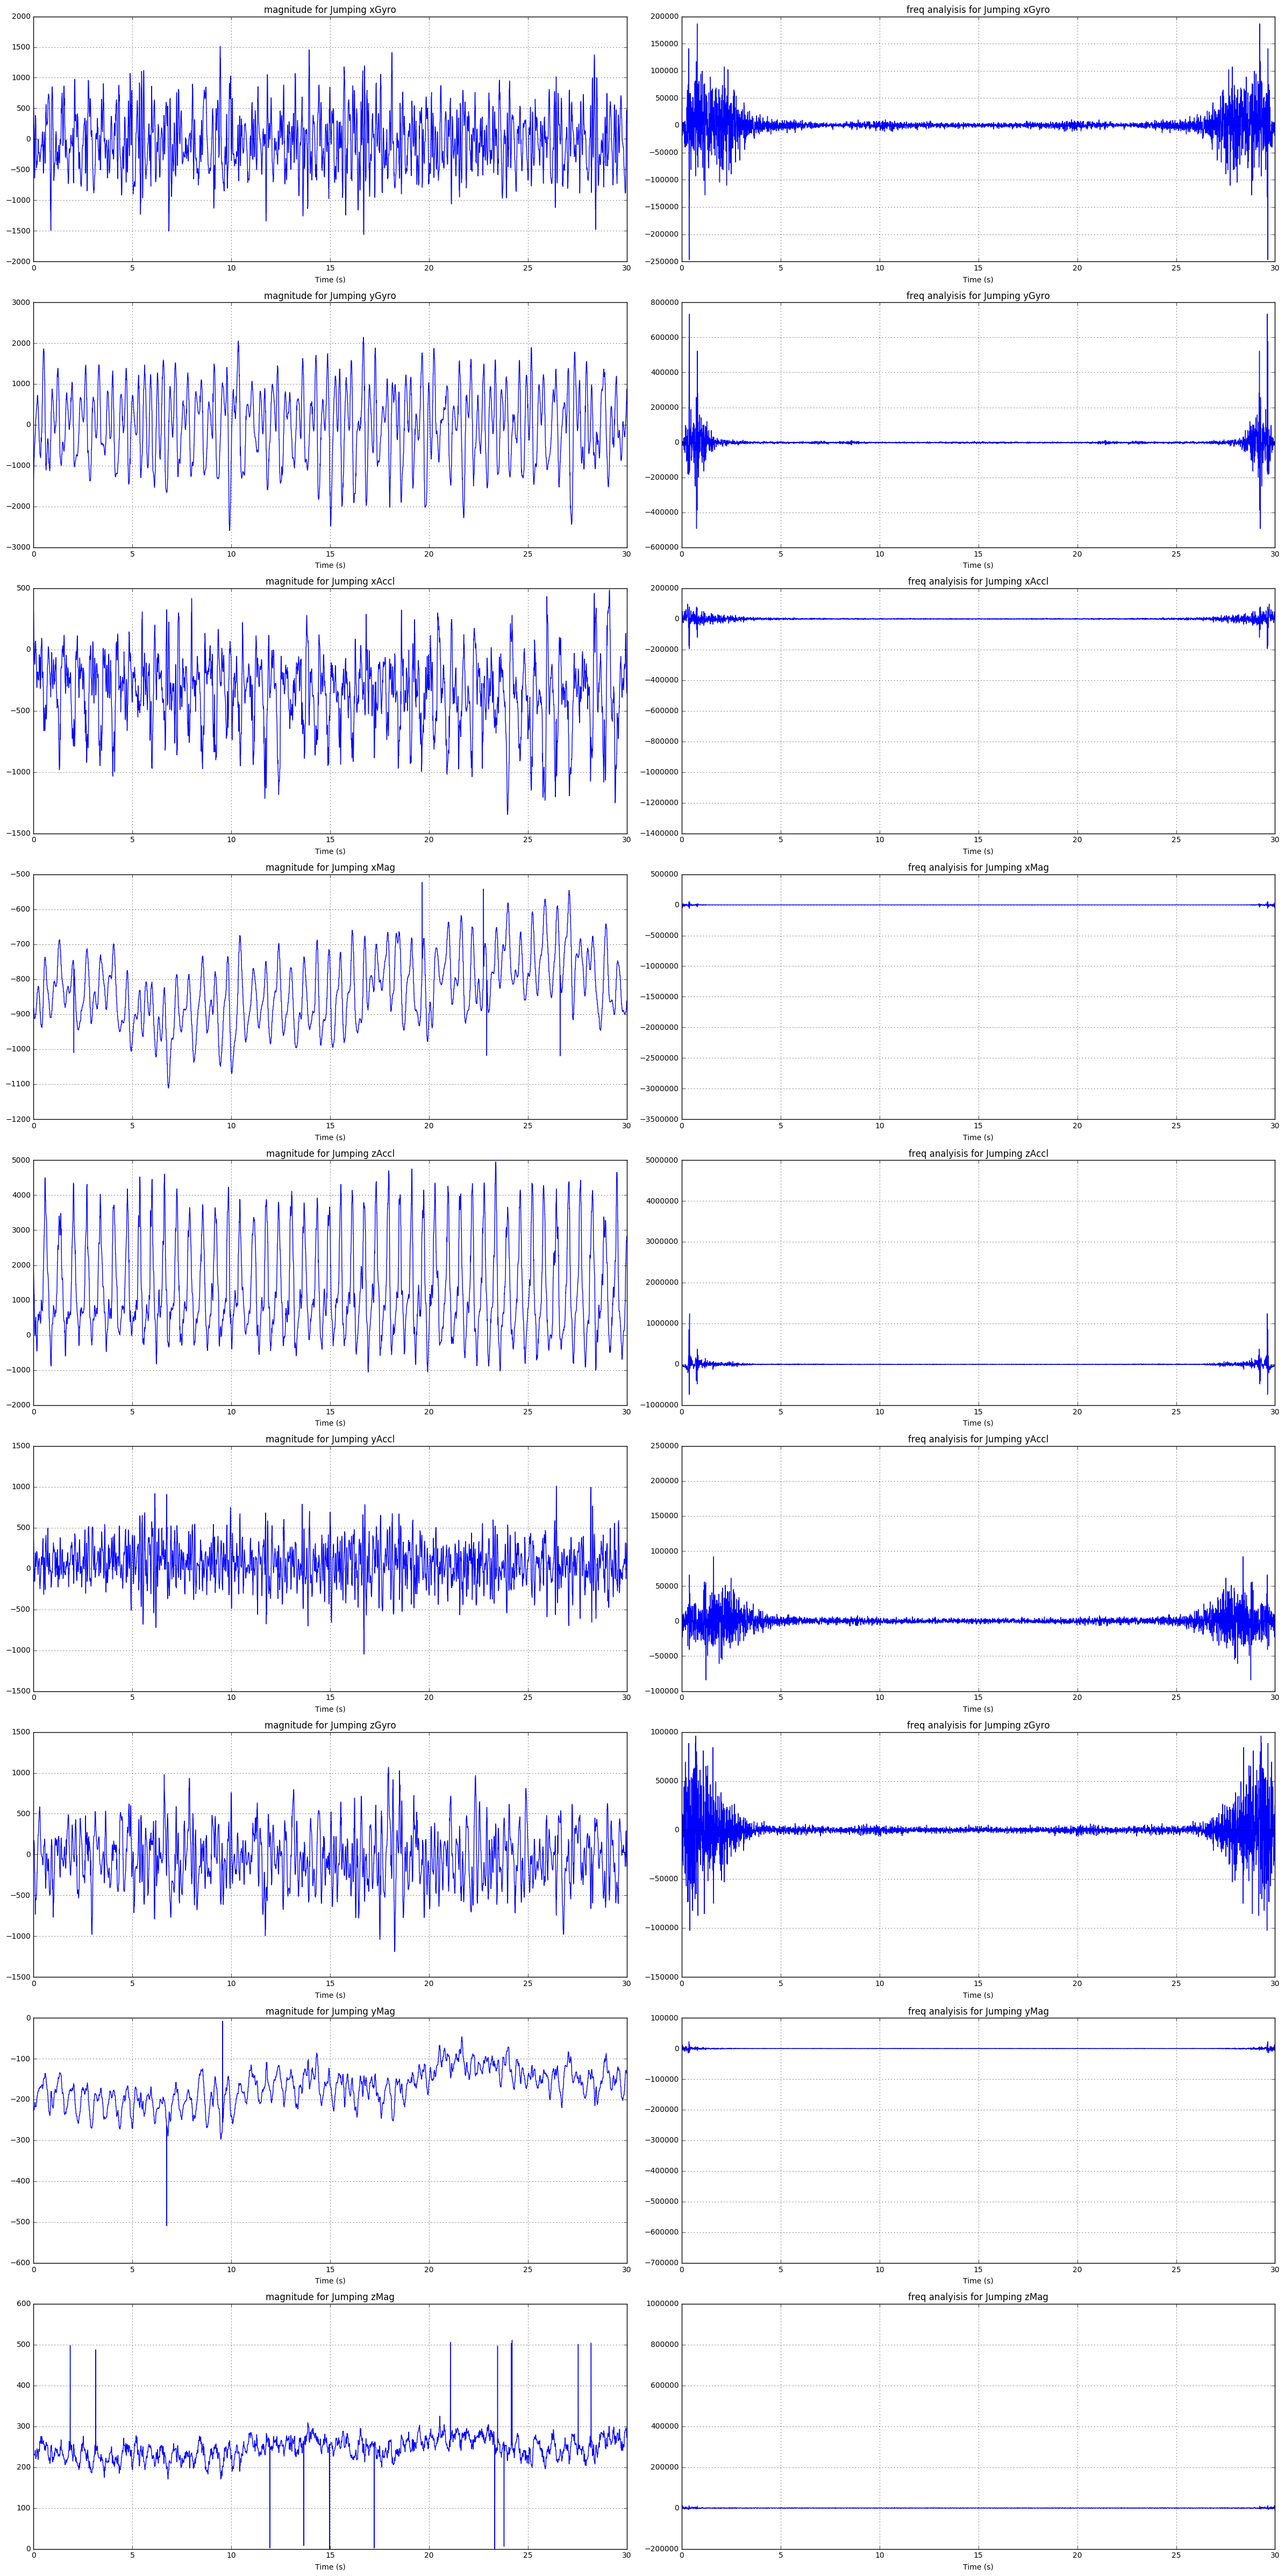

## Driving Graphs

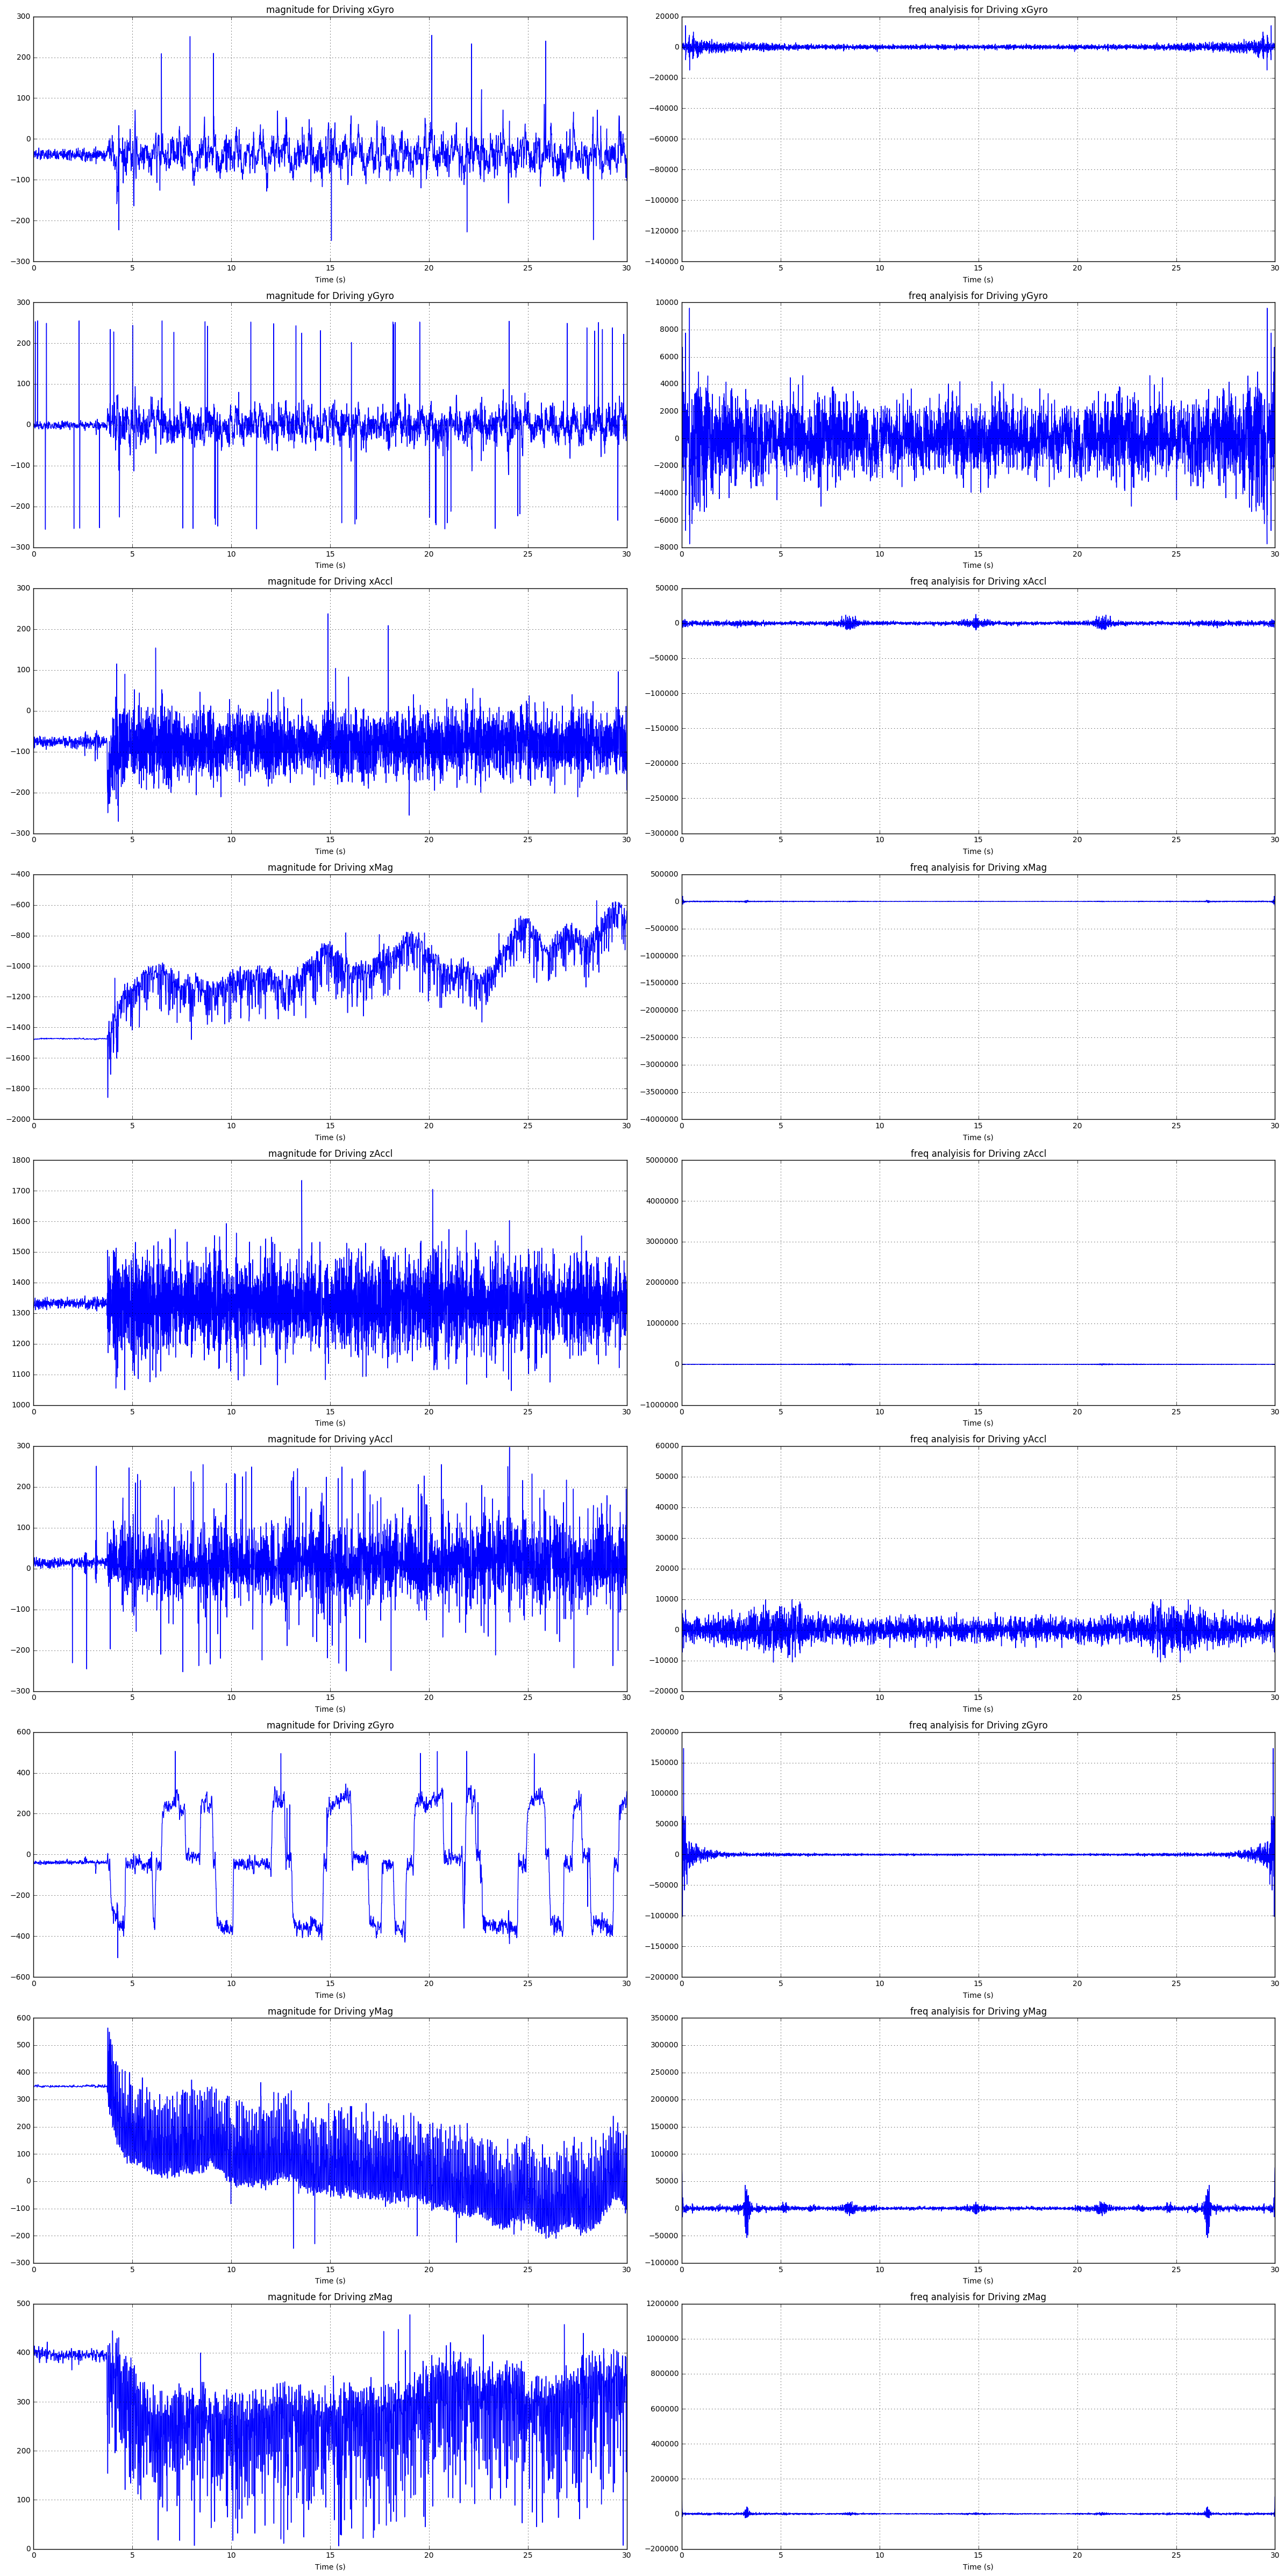

In [18]:
from IPython.display import display, Markdown

def displayFile(filepath, type):
    display(Markdown("## %s Graphs" % type))
    with open(filepath) as f:
        rawdata = f.read()
    log = Log(rawdata)
    log.showPlot()

displayFile("logs/activity-team2-Jumping-0.txt", "Jumping")
    
displayFile("logs/activity-team2-Driving-0.txt", "Driving")


We observed that the range of values, and the period, are significantly more different accross different measurement types as compared within types. This is how we settled on using `ymin`, `ymax`, and the number of "peaks" (as an approximation for period) in our model. 

We began working on our model by writing some functions that would help us determine which set of measurements would be best. This allows us to play around with what values we want to use for each measurement.

In [19]:
from sklearn.cluster import KMeans
import numpy as np

measurements = ["xGyro","yGyro","xAccl","xMag","zAccl","yAccl","zGyro","yMag","zMag"]

def testMultipleVars(logs, ylabels):
    """
    given multiple variables, we test the current model's results 
    when clustering with these variables.
    """
    points = map(lambda x: x.getMultipleMeasurements(ylabels), logs)
    kmeans = KMeans(n_clusters=2, random_state=0).fit(points)
    labels = kmeans.labels_
    return labels

def checkGroundTruth(logs, labels, expected):
    """
    comparing the clustering results to the ground truth
    """
    if sum(labels) > len(labels) // 2:
        for i in range(len(labels)):
            labels[i] = 1 - labels[i]
    res = {}
    if (len(logs) != len(labels)):
        return 
    for i in range(len(logs)):
        unexpected = 1
        if logs[i].type == expected and labels[i] == 1:
            unexpected = 0
        if logs[i].type != expected and labels[i] == 0:
            unexpected = 0
        if logs[i].type in res:
            res[logs[i].type] += unexpected
        else:
            res[logs[i].type] = unexpected
    return res

def perfectFit(logs, labels, expected):
    """
    checking whether set of measurements provides a model that is a perfect
    fit.
    """
    groundTruth = checkGroundTruth(logs, labels, expected)
    for g in groundTruth:
        if groundTruth[g] != 0:
            return False
    return True

def checkCombos(logs, categories):
    """
    checking each combination of measurements, we return one with a smallest
    number of variables that is correct, if one exists
    """
    for expected in categories:
        for i in range(1,len(measurements) + 1):
            for ylabels in combinations(np.array(measurements), i):
                labels = testMultipleVars(logs, ylabels)
                if perfectFit(logs, labels, expected):
                    print(expected, ylabels)
                    return expected, ylabels

Using these functions, we obtained a set of measurements that we would use to make our predictions. As we continued to improve the set of values we got from each log, we would use these functions to see how well it works. Using only `ymin` and `ymax`, we were able to separate Driving from Walking using six different measurements. When we added peak estimation, we brought this down to two measurements, `xGyro` and `yAccl`. We believe that a minimal model is best since this impoves efficiency and space requirements, so we saw this as an improvement.

Using these results, we made a function to test a new point, so that we could make predictions.

In [21]:
def predictNewPoint(point, folder):
    """determine which category a new point falls into"""
    categories = ["Walking", "Jumping", "Driving", "Standing"]
    prediction = getPrediction(point, folder, categories, \
        ['xGyro', 'xAccl', 'zAccl'])
    if prediction == 1:
        return "Jumping"
    categories.remove("Jumping")
    prediction = getPrediction(point, folder, categories, \
        ['yGyro', 'xMag', 'yAccl', 'yMag'])
    if prediction == 0:
        return "Standing"
    categories.remove("Standing")
    prediction = getPrediction(point, folder, categories, \
        ['xGyro', 'yAccl'])
    if prediction == 1:
        return "Walking"
    if prediction == 0:
        return "Driving"

However, this function is inefficient, since... so we improved it by..